In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output
import seaborn as sns
from pandas import DataFrame as df
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.
import xgboost as xgb
from sklearn.metrics import roc_auc_score

In [4]:
train = pd.read_csv("train.csv",sep=",",index_col=0)
test=pd.read_csv("test.csv",sep=",",index_col=0)

(array([45956.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 30064.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <a list of 10 Patch objects>)

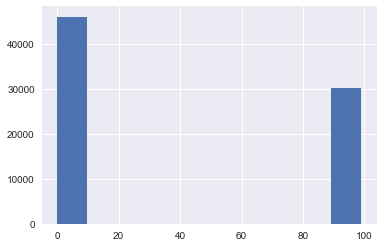

In [172]:
plt.hist(train.iloc[:,193])

In [173]:
train.iloc[:,193].value_counts()

99    30064
3     22177
1     14664
2      8704
0       411
Name: var36, dtype: int64

In [5]:
# change wierd val to NaN
# var_36= no.193
train.iloc[:,193].value_counts()
train["var36"].loc[train["var36"] == 99]  = np.NaN
test["var36"].loc[test["var36"] == 99]  = np.NaN
for i in range(194,220):
    col=train.columns[i]
#     print(train[col].isna().sum())
    train[col].loc[train[col] >=9999999999]  = np.NaN
    test[col].loc[test[col] >=9999999999]  = np.NaN
test["var3"].loc[test["var3"] == -999999]  = np.NaN
train["var3"].loc[train["var3"] == -999999]  = np.NaN

/Users/apple/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [176]:
# n,p = train.shape
# for i in range(p):
# #     print([i,train.iloc[:,i].dtype,np.min(train.iloc[:,i]),np.max(train.iloc[:,i])])
#     if np.round(train.iloc[:,i].isna().sum()/n,4)>0.2:
#         print(i)
# #         check the most % missing value

193


In [6]:
# add a new feature for var 36 missing
train['var36_nan']=train.iloc[:,193].isna()*1
test['var36_nan']=test.iloc[:,193].isna()*1

In [7]:
for col in train.columns:
    if train[col].isna().sum()>0:
        if train[col].dtype == "int64":
            # train[col].fillna(value=df.mode(train[col],skipna=True))
            train[col].loc[train[col].isna()] = df.mode(train[col],skipna=True)
            test[col].loc[test[col].isna()] = df.mode(train[col],skipna=True)
        else:
            # train[col].fillna(value=df.median(train[col],skipna=True))
            train[col].loc[train[col].isna()] = df.median(train[col],skipna=True)
            test[col].loc[test[col].isna()] = df.median(train[col],skipna=True)

/Users/apple/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
# Drop constant features
features_to_drop = []
for f in train.columns:
	if len(train[f].value_counts())==1:
		features_to_drop.append(f)
print(len(features_to_drop))
train = train.drop(features_to_drop,axis=1)
test=test.drop(features_to_drop,axis=1)

44


In [11]:
#remove features with overly unblanced distribution
features_to_drop = []
for f in train.columns:
	train_cnt = train[f].value_counts()/len(train)
	if (train_cnt.values[0]>0.99):
# 		print(f)
		features_to_drop.append(f)
print(len(features_to_drop))		
train = train.drop(features_to_drop,axis=1)
test = test.drop(features_to_drop,axis=1)

177


In [12]:
# drop equal features	
import itertools
combn2 = itertools.combinations(train.columns, 2)
features_to_drop = []
for f1,f2 in combn2:
#     print(f1,f2)
	if (f1 not in features_to_drop) & (f2 not in features_to_drop):
# 		if np.sum(data_X[f1].values-data_X[f2].values)==0:
		if np.equal(train[f1],train[f2]).all():
# 			print(f1+' '+f2)
			features_to_drop.append(f2)
print(len(features_to_drop))
train = train.drop(features_to_drop,axis=1)
test = test.drop(features_to_drop,axis=1)

6


In [14]:
n,p = train.shape
from sklearn.linear_model import LogisticRegression 

In [15]:
ct = 0
all_roc =[]
for i in range(p):
    if train.iloc[:,i].dtype == "int64":
        N = (len(train.iloc[:,i].value_counts()))
        if N > 2:
            X =  np.full([n,2],1)
            X[:,1] = train.iloc[:,i]
            clf = LogisticRegression().fit(X,train["TARGET"]) # continuous
            clf_roc = roc_auc_score(train["TARGET"], clf.predict_proba(X)[:,1])
            
            
            one_hot=pd.get_dummies(train.iloc[:,i])
            
            clf2 = LogisticRegression().fit(one_hot,train["TARGET"]) # continuous
            clf_roc2 = roc_auc_score(train["TARGET"], clf2.predict_proba(one_hot)[:,1])
#             clf_roc2 = 0
            
            all_roc.append([i,clf_roc,clf_roc2,clf_roc2-clf_roc])
            #print(N)
            ct += 1
            train.iloc[:,i]
            
print(ct)  

/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 

/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 

/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 

/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 

65


(array([42.,  2.,  9.,  4.,  2.,  0.,  2.,  1.,  1.,  2.]),
 array([-0.00017805,  0.00740422,  0.01498648,  0.02256875,  0.03015102,
         0.03773329,  0.04531556,  0.05289783,  0.0604801 ,  0.06806237,
         0.07564463]),
 <a list of 10 Patch objects>)

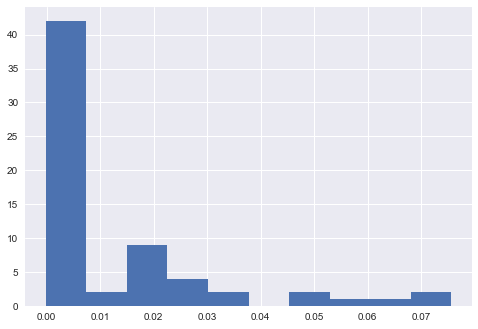

In [16]:
cresu = df(all_roc,columns = ["ID","AUC1","AUC2","AUC_d"])
plt.hist(cresu['AUC_d'])

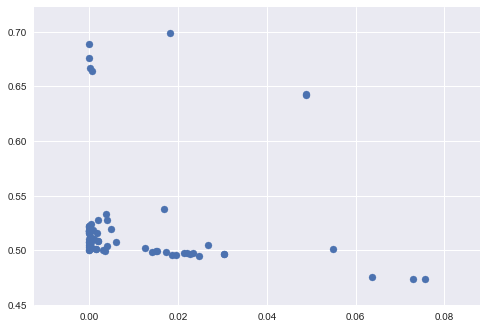

In [17]:
plt.scatter(cresu['AUC_d'],cresu['AUC1'])

In [20]:
ct = 0
new_train=train.copy()
new_test=test.copy()
for i in range(p):
    if train.iloc[:,i].dtype == "int64":
        N = (len(train.iloc[:,i].value_counts()))
        if N > 2:
            # print(cresu.iloc[ct,:])
            if cresu['AUC_d'][ct] > 0.04:
                
                two_hot_train = np.full([n,2],0)
                two_hot_test=np.full([len(test),2],0)
                a = train.iloc[:,i].value_counts().index[0:2]
#                 b = test.iloc[:,i].value_counts().index[0:2]
                two_hot_train[train.iloc[:,i] == a[0],0] = 1
                two_hot_train[train.iloc[:,i] == a[1],1] = 1
                two_hot_test[test.iloc[:,i] == a[0],0] = 1
                two_hot_test[test.iloc[:,i] == a[1],1] = 1
                
                
                
                new_train.iloc[:,i]=two_hot_train[:,0]
                new_train['dummy'+str(ct) ] = two_hot_train[:,1]
                new_test.iloc[:,i]=two_hot_test[:,0]
                new_test['dummy'+str(ct) ] = two_hot_test[:,1]
                
#                 clf2 = LogisticRegression().fit(two_hot,train["TARGET"]) # continuous
#                 clf_roc2 = roc_auc_score(train["TARGET"], clf2.predict_proba(two_hot)[:,1])
                
#                 print([cresu.iloc[ct,0:3],clf_roc2])
            ct += 1
            
# print(ct)  

In [21]:
print(new_train.info())
print(new_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76020 entries, 1 to 151838
Columns: 150 entries, var3 to dummy64
dtypes: float64(45), int64(105)
memory usage: 87.6 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 75818 entries, 2 to 151837
Columns: 149 entries, var3 to dummy64
dtypes: float64(45), int64(104)
memory usage: 86.8 MB
None


In [192]:
def Split(dataset,y,ratio = 0.8):
    
	class0 = dataset[dataset[y] == 0]
	class1 = dataset[dataset[y] == 1]
	n0,_ = class0.shape
	n1,_ = class1.shape
	n0_train,n1_train = round(ratio*n0),round(ratio*n1)
	class0 = class0.sample(frac = 1)
	class1 = class1.sample(frac = 1)
	train = pd.concat([class0.iloc[0:n0_train,:],class1.iloc[0:n1_train,:]],axis = 0)
	test = pd.concat([class0.iloc[n0_train:n0,:],class1.iloc[n1_train:n1,:]],axis = 0)
	return [train,test]


In [197]:
Train1, Test = Split(new_train,'TARGET')

In [198]:
Train, Valid = Split(Train1,'TARGET',0.6)

In [204]:
Test.to_csv('test_12_3.csv', sep=',')

In [205]:
Train.to_csv("train_12_3.csv", sep=',')

In [206]:
Valid.to_csv("valid_12_3.csv", sep=',')

In [24]:
new_test.to_csv('test_cleaned_12_9.csv',sep=',')